# Model Performance & Allocation Analysis
    
This notebook visualizes the performance of the 3-model system (Return, Volatility, Market Regime) and the final allocation logic.
It helps identify why penalties (Volatility or Return) might be high.


In [ ]:
# Auto-Save Plots to Experiment Folder
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Find latest experiment folder
project_root = Path('..') # Assuming notebook is in notebooks/
exp_dir = project_root / 'experiments'
if exp_dir.exists():
    experiments = sorted([d for d in exp_dir.iterdir() if d.is_dir() and d.name.startswith('exp_')], key=lambda x: x.name)
    if experiments:
        LATEST_EXP_PATH = experiments[-1]
        print(f"📂 Saving plots to: {LATEST_EXP_PATH}")
    else:
        LATEST_EXP_PATH = None
        print("⚠️ No experiment folder found.")
else:
    LATEST_EXP_PATH = None

def save_plot(filename):
    if LATEST_EXP_PATH:
        path = LATEST_EXP_PATH / filename
        plt.savefig(path, bbox_inches='tight')
        print(f"💾 Saved: {path.name}")


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load Data
project_root = Path.cwd().parent
if str(Path.cwd()).endswith('scripts'): # If running from scripts dir
    project_root = Path.cwd().parent
elif str(Path.cwd()).endswith('notebooks'):
    project_root = Path.cwd().parent

# Load Test Predictions (Last 180 days)
test_path = project_root / 'results' / 'test_predictions.csv'
if not test_path.exists():
    print(f"File not found: {test_path}")
else:
    df = pd.read_csv(test_path)
    print(f"Loaded {len(df)} rows from {test_path}")
    display(df.head())


Loaded 180 rows from /Users/gimjunseog/projects/quant_strategy/results/test_predictions.csv


,date_id,actual_return,pred_return,pred_risk,pred_risk2,allocation
0,8841,0.006791,-0.001682,0.006927,-0.011865,0.000000
1,8842,0.000761,-0.001355,0.009211,-0.008265,0.000000
2,8843,-0.003221,0.002516,0.007501,-0.007838,1.174217
3,8844,0.010558,0.001576,0.009649,-0.009299,0.571616
4,8845,-0.000049,-0.000975,0.007414,-0.007937,0.000000


## 1. Return Model Analysis (Model A)
Check if the return predictions (Direction & Magnitude) align with actual returns.
- **IC (Information Coefficient)**: Correlation between Pred and Actual.
- **Scatter Plot**: Pred vs Actual.


Information Coefficient (IC): 0.1353


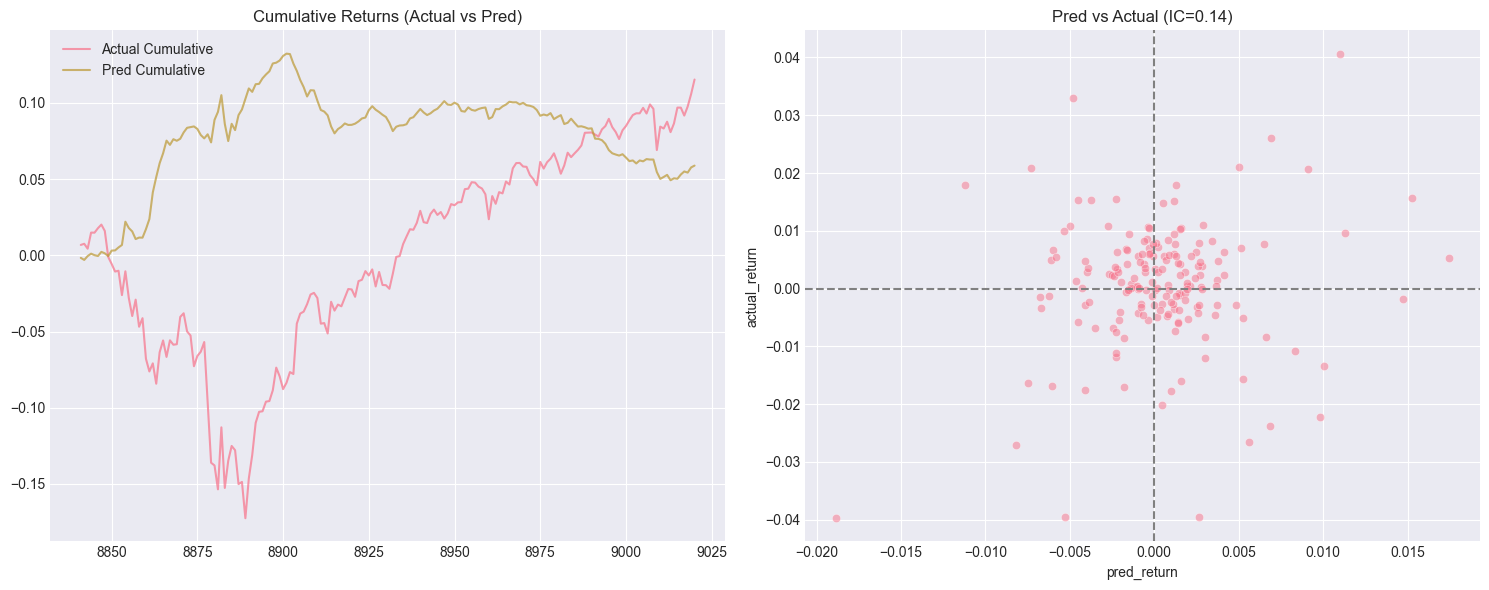

In [37]:
# Metrics
ic = df['pred_return'].corr(df['actual_return'])
print(f"Information Coefficient (IC): {ic:.4f}")

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Time Series
ax[0].plot(df['date_id'], df['actual_return'].cumsum(), label='Actual Cumulative', alpha=0.7)
ax[0].plot(df['date_id'], df['pred_return'].cumsum(), label='Pred Cumulative', alpha=0.7)
ax[0].set_title("Cumulative Returns (Actual vs Pred)")
ax[0].legend()

# Scatter
sns.scatterplot(data=df, x='pred_return', y='actual_return', ax=ax[1], alpha=0.5)
ax[1].set_title(f"Pred vs Actual (IC={ic:.2f})")
ax[1].axhline(0, color='grey', linestyle='--')
ax[1].axvline(0, color='grey', linestyle='--')

plt.tight_layout()
save_plot('plot_cell_4.png')
plt.show()


## 2. Risk Model Analysis (Model B - Volatility)
Check if the risk model correctly predicts high volatility (Absolute Returns).
- **Target**: `abs(actual_return)`
- **Goal**: Predict higher values when actual volatility is high.


Risk Correlation: 0.5067


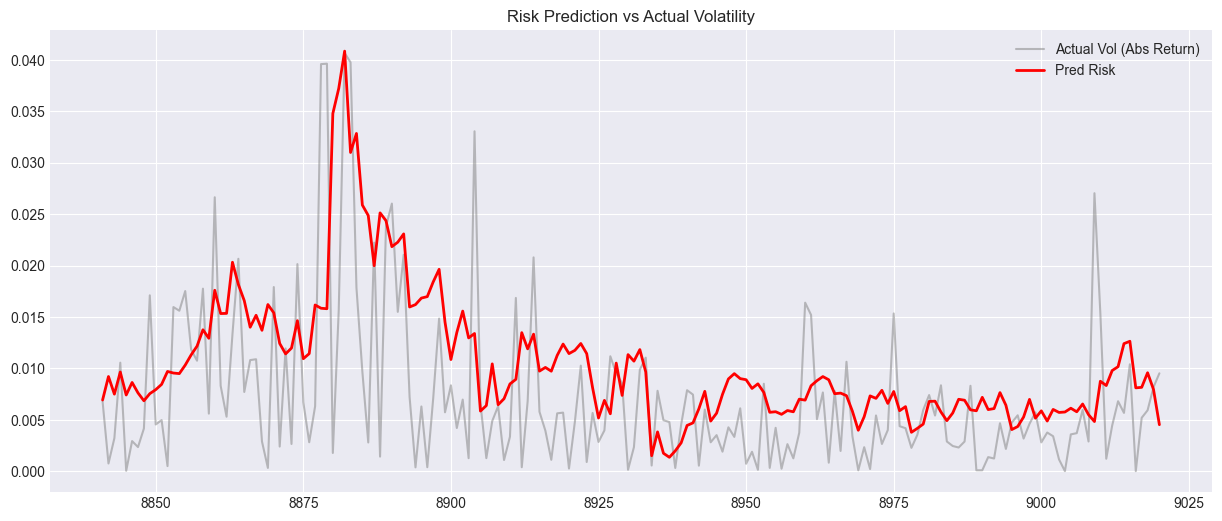

In [38]:
# Metrics
risk_corr = df['pred_risk'].corr(df['actual_return'].abs())
print(f"Risk Correlation: {risk_corr:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['date_id'], df['actual_return'].abs(), label='Actual Vol (Abs Return)', alpha=0.5, color='grey')
plt.plot(df['date_id'], df['pred_risk'], label='Pred Risk', color='red', linewidth=2)
plt.title("Risk Prediction vs Actual Volatility")
plt.legend()
save_plot('plot_cell_6.png')
plt.show()


## 3. Market Regime Analysis (Model C)
Check if the market regime model correctly identifies crashes.
- **Goal**: Predict negative values during market downturns.


Market Model Correlation: 0.0266


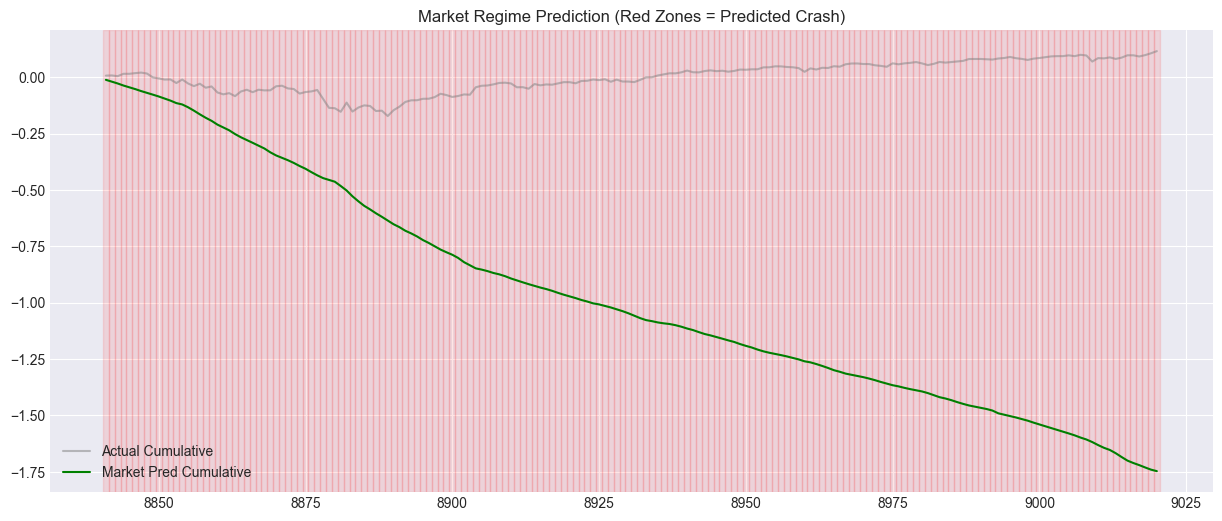

In [39]:
if 'pred_risk2' in df.columns:
    # Metrics
    # Assuming risk2 target was market return (or proxy)
    # We compare with actual return for simplicity (assuming high correlation with market)
    mkt_corr = df['pred_risk2'].corr(df['actual_return'])
    print(f"Market Model Correlation: {mkt_corr:.4f}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(df['date_id'], df['actual_return'].cumsum(), label='Actual Cumulative', color='grey', alpha=0.5)
    
    # Color background based on Regime Prediction
    # Red zone if pred_risk2 < 0 (Crash predicted)
    y_min, y_max = ax.get_ylim()
    
    # Find crash zones
    crash_mask = df['pred_risk2'] < 0
    # Simple fill (might be slow for many points, but fine for 180)
    for idx in df[crash_mask].index:
        ax.axvspan(df.loc[idx, 'date_id']-0.5, df.loc[idx, 'date_id']+0.5, color='red', alpha=0.1)
        
    ax.plot(df['date_id'], df['pred_risk2'].cumsum(), label='Market Pred Cumulative', color='green')
    ax.set_title("Market Regime Prediction (Red Zones = Predicted Crash)")
    ax.legend()
save_plot('plot_cell_8.png')
    plt.show()
else:
    print("Risk Model 2 predictions not found.")


## 4. Allocation & Penalties
Analyze the final allocation and its impact on penalties.
- **Volatility Penalty**: Triggered if `Strategy Vol / Market Vol > 1.2`.
- **Return Penalty**: Triggered if `Strategy Return < Market Return`.


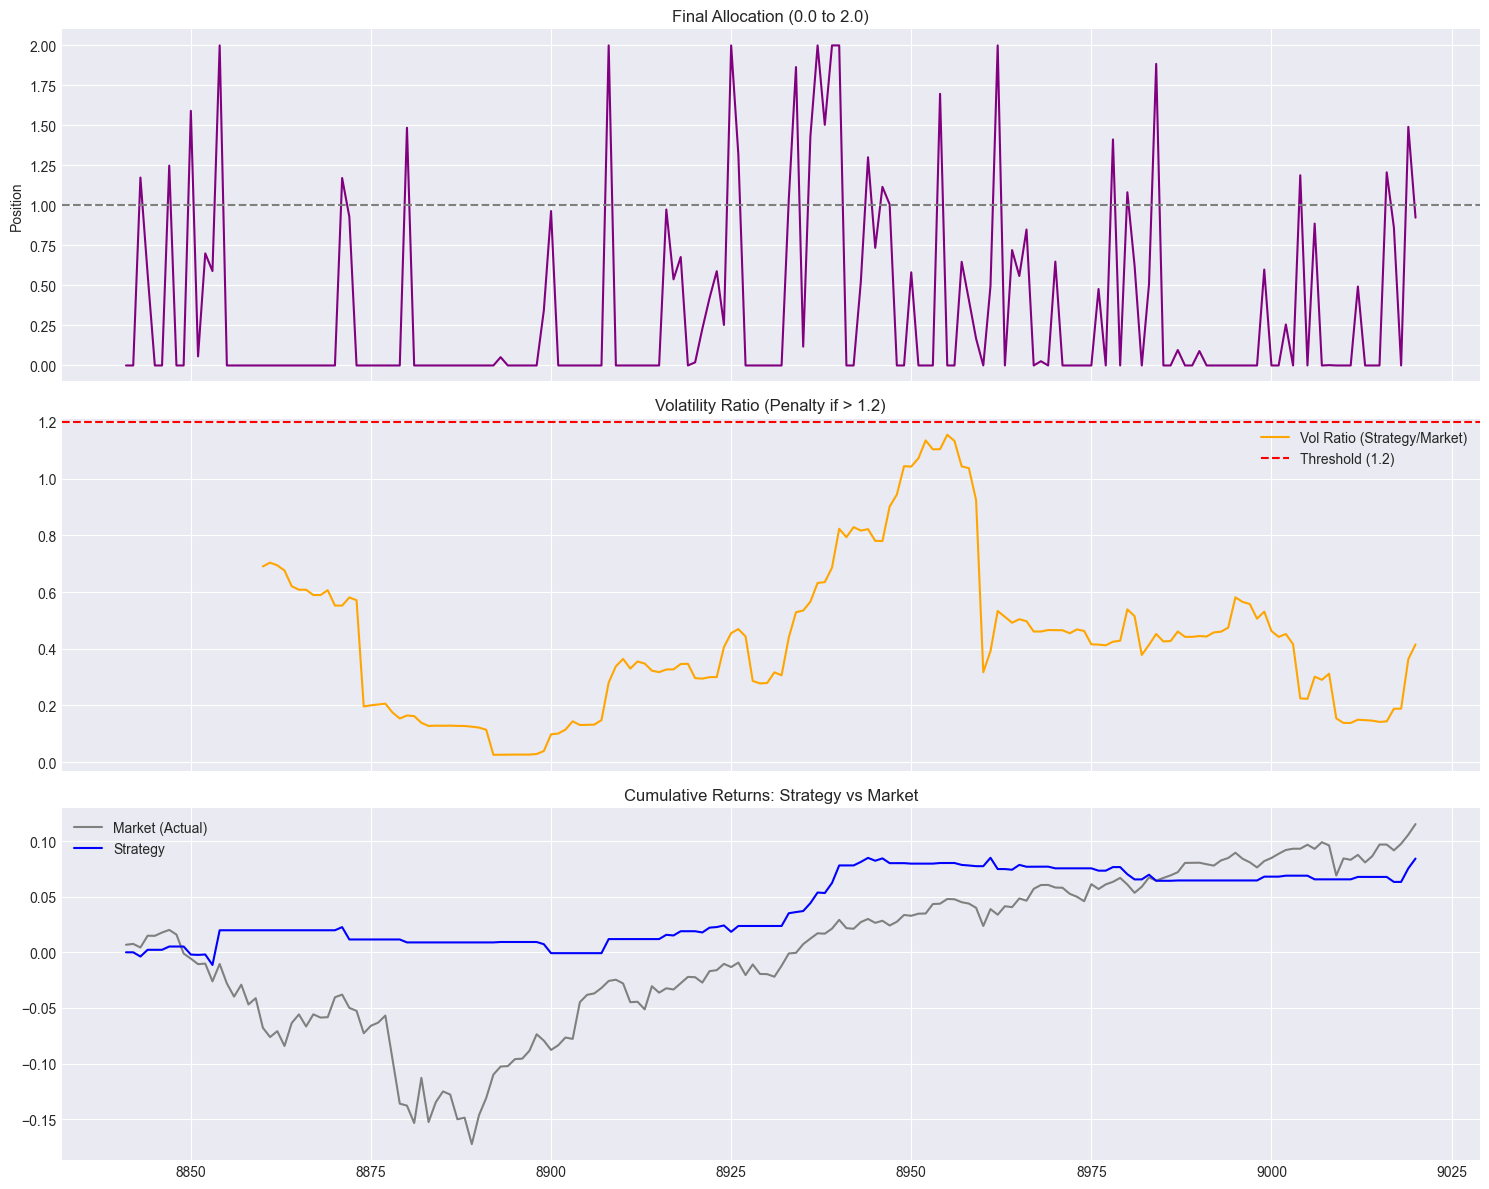

In [40]:
# Calculate Strategy Returns
df['strategy_return'] = df['allocation'] * df['actual_return']

# Rolling Volatility (20 days)
window = 20
df['strategy_vol'] = df['strategy_return'].rolling(window).std() * np.sqrt(252) * 100
df['market_vol'] = df['actual_return'].rolling(window).std() * np.sqrt(252) * 100
df['vol_ratio'] = df['strategy_vol'] / (df['market_vol'] + 1e-6)

# Plot Allocation
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# 1. Allocation
ax[0].plot(df['date_id'], df['allocation'], label='Allocation', color='purple')
ax[0].axhline(1.0, linestyle='--', color='grey')
ax[0].set_title("Final Allocation (0.0 to 2.0)")
ax[0].set_ylabel("Position")

# 2. Volatility Ratio
ax[1].plot(df['date_id'], df['vol_ratio'], label='Vol Ratio (Strategy/Market)', color='orange')
ax[1].axhline(1.2, color='red', linestyle='--', label='Threshold (1.2)')
ax[1].set_title("Volatility Ratio (Penalty if > 1.2)")
ax[1].legend()

# 3. Cumulative Returns
ax[2].plot(df['date_id'], df['actual_return'].cumsum(), label='Market (Actual)', color='grey')
ax[2].plot(df['date_id'], df['strategy_return'].cumsum(), label='Strategy', color='blue')
ax[2].set_title("Cumulative Returns: Strategy vs Market")
ax[2].legend()

plt.tight_layout()
save_plot('plot_cell_10.png')
plt.show()


# 4. OOF Deep Dive Analysis
Analyzing the Out-of-Fold (OOF) predictions to understand model behavior across different market regimes and identify strengths/weaknesses.

In [ ]:
# Load OOF Data
oof_path = project_root / 'results' / 'oof_predictions.csv'
if not oof_path.exists():
    print(f"File not found: {oof_path}")
else:
    oof_df = pd.read_csv(oof_path)
    print(f"Loaded {len(oof_df)} rows from {oof_path}")
    display(oof_df.head())

## 4.1 Market Regime Analysis (Volatility Quintiles)
How does the model perform in calm vs. volatile markets?
- **Method**: Divide data into 5 regimes based on Rolling Volatility (20D Std).
- **Metrics**: Sharpe Ratio, Win Rate, and Average Return per regime.

In [ ]:
# Calculate Rolling Volatility (Market Regime Proxy)
oof_df['market_vol_20d'] = oof_df['actual_return'].rolling(20).std()

# Drop NaN from rolling
analysis_df = oof_df.dropna(subset=['market_vol_20d']).copy()

# Create Volatility Quintiles (Q1=Calm, Q5=Volatile)
analysis_df['vol_regime'] = pd.qcut(analysis_df['market_vol_20d'], 5, labels=['Q1 (Calm)', 'Q2', 'Q3', 'Q4', 'Q5 (Volatile)'])

# Calculate Performance by Regime
regime_stats = analysis_df.groupby('vol_regime').apply(lambda x: pd.Series({
    'Sharpe': x['allocation'].mul(x['actual_return']).mean() / x['allocation'].mul(x['actual_return']).std() * np.sqrt(252) if x['allocation'].mul(x['actual_return']).std() != 0 else 0,
    'Avg_Return': x['allocation'].mul(x['actual_return']).mean() * 252,
    'Win_Rate': (x['allocation'].mul(x['actual_return']) > 0).mean(),
    'Avg_Allocation': x['allocation'].mean(),
    'Count': len(x)
}))

print("Performance by Market Regime (Volatility):")
display(regime_stats)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
regime_stats['Sharpe'].plot(kind='bar', ax=ax[0], title='Sharpe Ratio by Volatility Regime', color='skyblue')
ax[0].axhline(0, color='grey', linestyle='--')
regime_stats['Avg_Allocation'].plot(kind='bar', ax=ax[1], title='Average Allocation by Regime', color='orange')
plt.tight_layout()
save_plot('plot_cell_14.png')
plt.show()

## 4.2 Prediction Quality Analysis (Return Deciles)
When the model predicts "High Return", does the market actually go up?
- **Method**: Divide `pred_return` into 10 Deciles.
- **Expectation**: Monotonic increase in Actual Return from D1 to D10.

In [ ]:
# Create Prediction Deciles
analysis_df['pred_decile'] = pd.qcut(analysis_df['pred_return'], 10, labels=False) + 1

# Calculate Avg Actual Return per Decile
decile_stats = analysis_df.groupby('pred_decile')['actual_return'].mean()

# Plot
plt.figure(figsize=(10, 6))
decile_stats.plot(kind='bar', color='teal', alpha=0.7)
plt.title("Average Actual Return by Prediction Decile (Monotonicity Check)")
plt.xlabel("Prediction Decile (1=Lowest Pred, 10=Highest Pred)")
plt.ylabel("Average Actual Return")
plt.axhline(0, color='grey', linestyle='--')
save_plot('plot_cell_16.png')
plt.show()

## 4.3 Error Analysis (Big Losses & Missed Opportunities)
Where did we lose money? Where did we miss out?

In [ ]:
# Calculate Strategy Returns
analysis_df['strat_return'] = analysis_df['allocation'] * analysis_df['actual_return']

# 1. Big Losses (Bottom 1% of Strategy Returns)
worst_days = analysis_df.nsmallest(int(len(analysis_df)*0.01), 'strat_return')
print("\n📉 Top 5 Worst Days (Big Losses):")
display(worst_days[['date_id', 'actual_return', 'pred_return', 'pred_risk', 'pred_risk2', 'allocation', 'strat_return']].head())

# 2. Missed Opportunities (Top 1% Market Returns where Allocation < 0.5)
missed_opps = analysis_df[(analysis_df['actual_return'] > analysis_df['actual_return'].quantile(0.99)) & (analysis_df['allocation'] < 0.5)]
print("\n🤷 Missed Opportunities (High Market Return, Low Allocation):")
display(missed_opps[['date_id', 'actual_return', 'pred_return', 'pred_risk', 'pred_risk2', 'allocation']].head())